# Imports and Data Generation

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [64]:
X = np.vstack((
    np.array([1, 1, 1]) + np.random.rand(10, 3),
    np.array([1, 1, -1]) + np.random.rand(10, 3),
    np.array([1, -1, 1]) + np.random.rand(10, 3),
    np.array([1, -1, -1]) + np.random.rand(10, 3),
    np.array([-1, 1, 1]) + np.random.rand(10, 3),
    np.array([-1, 1, -1]) + np.random.rand(10, 3),
    np.array([-1, -1, 1]) + np.random.rand(10, 3),
    np.array([-1, -1, -1]) + np.random.rand(10, 3),
))
y_ally = np.vstack((np.ones((40, 1)), np.zeros((40, 1))))
y_advr_y = np.vstack((np.ones((20, 1)), np.zeros((20, 1)), np.ones((20, 1)), np.zeros((20, 1))))
y_advr_z = np.vstack((np.ones((10, 1)), np.zeros((10, 1)), np.ones((10, 1)), np.zeros((10, 1)), 
                     np.ones((10, 1)), np.zeros((10, 1)), np.ones((10, 1)), np.zeros((10, 1))))

X.shape, y_ally.shape, y_advr_y.shape, y_advr_z.shape

((80, 3), (80, 1), (80, 1), (80, 1))

# Utility

In [133]:
def class_plot(X_input, aspect=True, title=False, orig=True, save=False):
    X_tsne = TSNE(n_components=3).fit_transform(X_input)
    X_pca = PCA(n_components=3).fit_transform(X_input)
    colors = ['r', 'b']
    markers = ['o', 'x', '*', 's', 'o', 'x', '*', 's']
    
    if orig:
        fig = plt.figure(figsize=(15,5))
        ax3 = fig.add_subplot(131, projection='3d')
        ax1 = fig.add_subplot(132, projection='3d')
        ax2 = fig.add_subplot(133, projection='3d')
        t3, t1, t2 = '(a)', '(b)', '(c)'
    else:
        fig = plt.figure(figsize=(10,5))
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')
        t1, t2 = '(a)', '(b)'
    if orig:
        m = 0
        for i in range(2):
            for j in range(2):
                for k in range(2):
                    tmp = X_input[np.intersect1d(np.intersect1d(
                        np.where(y_ally == i)[0], 
                        np.where(y_advr_y == j)[0]),
                        np.where(y_advr_z == k)[0]
                    )]
                    ax3.scatter(tmp[:, 0], tmp[:, 1], tmp[:, 2], c=colors[i], marker=markers[m])
                    m += 1
        ax3.set_title(t3, y=-0.2)
        
    m = 0
    for i in range(2):
        for j in range(2):
            for k in range(2):
                tmp = X_pca[np.intersect1d(np.intersect1d(
                    np.where(y_ally == i)[0], 
                    np.where(y_advr_y == j)[0]),
                    np.where(y_advr_z == k)[0]
                )]
                ax1.scatter(tmp[:, 0], tmp[:, 1], tmp[:, 2], c=colors[i], marker=markers[m])
                m += 1
    ax1.set_title(t1, y=-0.2)
    
    m = 0
    for i in range(2):
        for j in range(2):
            for k in range(2):
                tmp = X_tsne[np.intersect1d(np.intersect1d(
                    np.where(y_ally == i)[0], 
                    np.where(y_advr_y == j)[0]),
                    np.where(y_advr_z == k)[0]
                )]
                ax2.scatter(tmp[:, 0], tmp[:, 1], tmp[:, 2], c=colors[i], marker=markers[m])
                m += 1
    ax2.set_title(t2, y=-0.2)

    if save:
        plt.savefig(save, dpi=300)
    else:
        plt.show()

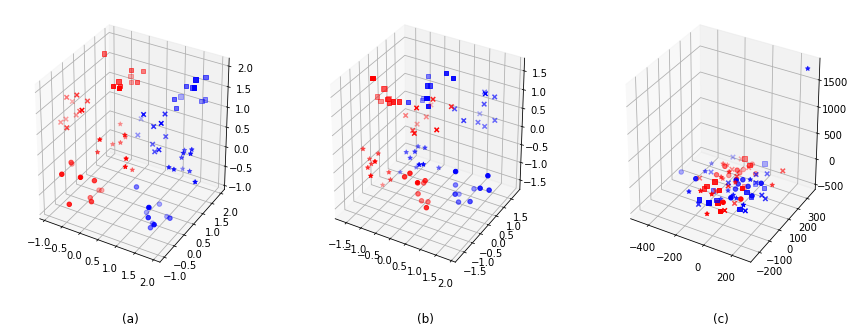

In [134]:
class_plot(X)

### Idea

Basically we are trying to learn represenations of any given data in another transformed axes where classification becomes easier along one label but becomes tougher along another one.

- Here we want to differentiate between the two circles while not being able to tell between the two semicircles

In [117]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

### Validation after scaling

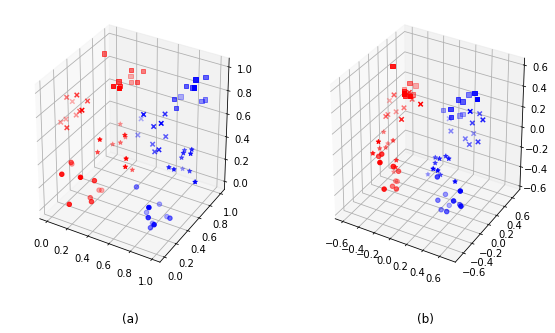

In [118]:
class_plot(X_normalized, title="Original Dataset")

# PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_normalized)

In [ ]:
class_plot(X_pca, title='PCA Represenation')

# AutoEncoder

In [120]:
import torch

In [ ]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size, encoding_dim, hidden_size):
        super(AutoEncoder, self).__init__()
        self.input_size = input_size
        self.encoding_dim = encoding_dim
        self.hidden_size = hidden_size
        
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        
        self.fc11 = torch.nn.Linear(self.hidden_size, self.encoding_dim)
        self.relu = torch.nn.ReLU()
        
        self.fc2 = torch.nn.Linear(self.encoding_dim, self.hidden_size)
        self.sigmoid = torch.nn.Sigmoid()
        
        
        self.fc22 = torch.nn.Linear(self.hidden_size, self.input_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def encoder(self, x):
        return self.sigmoid(self.fc11(self.sigmoid(self.fc1(x))))

    def decoder(self, y):
        return self.sigmoid(self.fc22(self.sigmoid(self.fc2(y))))
    
    def forward(self, x):
        y = self.encoder(x)
        x = self.decoder(y)
        return x

In [ ]:
auto_encoder = AutoEncoder(
    input_size=X_normalized.shape[1],
    encoding_dim=X_normalized.shape[1], 
    hidden_size=X_normalized.shape[1]*2
)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam
ae_optimizer = optimizer(auto_encoder.parameters(), lr = 0.01)

In [121]:
X_torch = torch.Tensor(X_normalized)
y_ally_torch = torch.Tensor(y_ally.reshape(-1, 1))
y_advr_y_torch = torch.Tensor(y_advr_y.reshape(-1, 1))
y_advr_z_torch = torch.Tensor(y_advr_z.reshape(-1, 1))

In [ ]:
print("epoch \t Aencoder_train")

ae_epoch = []
ae_train = []

for epoch in range(10001):
    auto_encoder.train()
    ae_optimizer.zero_grad()
    
    X_torch_hat = auto_encoder(X_torch)
    ae_loss = criterion(X_torch_hat, X_torch)
    ae_loss.backward(retain_graph=True)
    ae_optimizer.step()
    
    ae_epoch.append(epoch)
    ae_train.append(ae_loss.item())
    
    if epoch%1000!=0:
        continue
    
    print('{} \t {:.8f}'.format(
        epoch, 
        ae_loss.item(),
    ))
    

plt.plot(ae_epoch, ae_train, 'r--')
plt.legend(['train_loss'])
plt.title("autoencoder training")
plt.show()

In [ ]:
X_autoencoded = auto_encoder.encoder(X_torch)

In [ ]:
class_plot(X_autoencoded.detach().numpy(), title='Autoencoder Representation')

In [ ]:
X_autodecoded = auto_encoder.decoder(X_autoencoded)

In [ ]:
class_plot(X_autodecoded.detach().numpy())

# Privacy GAN

In [122]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.batchnorm = torch.nn.BatchNorm1d(self.hidden_size)
    def forward(self, x):
        hidden = self.fc1(x)
#         hidden = self.batchnorm(hidden)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.tanh(output)
        return output


class Ally(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Ally, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.batchnorm = torch.nn.BatchNorm1d(self.hidden_size)
    def forward(self, x):
        hidden = self.fc1(x)
#         hidden = self.batchnorm(hidden)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Adversary(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Adversary, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.batchnorm = torch.nn.BatchNorm1d(self.hidden_size)
    def forward(self, x):
        hidden = self.fc1(x)
#         hidden = self.batchnorm(hidden)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [136]:
def train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True):
    encoding_dimension = 3
    encoder = Encoder(
        input_size=X_torch.shape[1], 
        hidden_size=encoding_dimension*16, 
        output_size=encoding_dimension*8)
    ally = Ally(
        input_size=encoding_dimension*8, 
        hidden_size=encoding_dimension*16, 
        output_size=y_ally_torch.shape[1])
    adversary_y = Adversary(
        input_size=encoding_dimension*8, 
        hidden_size=encoding_dimension*16, 
        output_size=y_advr_y_torch.shape[1])
    adversary_z = Adversary(
        input_size=encoding_dimension*8, 
        hidden_size=encoding_dimension*16, 
        output_size=y_advr_z_torch.shape[1])

    
    
    criterion = torch.nn.BCEWithLogitsLoss()
    kldiv = torch.nn.KLDivLoss()
    l1_loss = torch.nn.L1Loss()
    optimizer = torch.optim.Adam
    encd_optimizer = optimizer(encoder.parameters(), lr = lr_encd)
    ally_optimizer = optimizer(ally.parameters(), lr=lr_ally)
    advr_y_optimizer = optimizer(adversary_y.parameters(), lr=lr_advr)
    advr_z_optimizer = optimizer(adversary_z.parameters(), lr=lr_advr)
    
    if debug:
        print("epoch \t encoder_train \t ally_train \t advr_y_train \t advr_z_train")

    g_epoch = []
    enc_train = []
    ally_train = []
    advr_y_train = []
    advr_z_train = []
    
    encoder.train()
    ally.train()
    adversary_y.train()
    adversary_z.train()

    for epoch in range(n_iter_gan):
        # set for training
        # Forward passv
        X_ganencoded = encoder(X_torch)
        y_ally_torch_hat = ally(X_ganencoded)
        y_advr_y_torch_hat = adversary_y(X_ganencoded)
        y_advr_z_torch_hat = adversary_z(X_ganencoded)
        # Compute Loss
        ally_loss = criterion(y_ally_torch_hat, y_ally_torch)
        advr_y_loss = -criterion(y_advr_y_torch_hat, y_advr_y_torch)
        advr_z_loss = -criterion(y_advr_z_torch_hat, y_advr_z_torch)
        encd_loss = ally_loss + advr_y_loss + advr_z_loss
        
        encd_optimizer.zero_grad()
        encd_loss.backward()
        encd_optimizer.step()

        for i in range(d_reps):
            X_ganencoded = encoder(X_torch)
            y_ally_torch_hat = ally(X_ganencoded)
            ally_optimizer.zero_grad()
            ally_loss = criterion(y_ally_torch_hat, y_ally_torch)
            ally_loss.backward()
            ally_optimizer.step()
            
            X_ganencoded = encoder(X_torch)
            y_advr_y_torch_hat = adversary_y(X_ganencoded)
            advr_y_optimizer.zero_grad()
            advr_y_loss = criterion(y_advr_y_torch_hat, y_advr_y_torch)
            advr_y_loss.backward()
            advr_y_optimizer.step()
            
            X_ganencoded = encoder(X_torch)
            y_advr_z_torch_hat = adversary_z(X_ganencoded)
            advr_z_optimizer.zero_grad()
            advr_z_loss = criterion(y_advr_z_torch_hat, y_advr_z_torch)
            advr_z_loss.backward()
            advr_z_optimizer.step()

        if plot:
            g_epoch.append(epoch)
            enc_train.append(encd_loss.item())
            ally_train.append(ally_loss.item())
            advr_y_train.append(advr_y_loss.item())
            advr_z_train.append(advr_z_loss.item())
            
        if epoch%500!=0 and (debug or plot):
            continue

        if debug:
            print('{} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f}'.format(
                epoch, 
                encd_loss.item(),
                ally_loss.item(),
                advr_y_loss.item(),
                advr_z_loss.item(),
            ))
        
        X_ganencoded = encoder(X_torch)
        class_plot(X_ganencoded.detach().numpy(), False, orig=False)

    if plot:
        plt.plot(g_epoch, enc_train, 'r')
        plt.plot(g_epoch, ally_train, 'b')
        plt.plot(g_epoch, advr_y_train, 'g')
        plt.plot(g_epoch, advr_z_train, 'g-')
        plt.legend([
            'encoder train loss', 
            'ally train loss',
            'advr y train loss',
            'advr z train loss'
        ])
        
        plt.xlabel('number of iterations')
        plt.ylabel('loss')
        plt.show() 

        return encoder  

- maximize the divergence
- no dimensionality reduction here

epoch 	 encoder_train 	 ally_train 	 advr_y_train 	 advr_z_train
0 	 -0.72411394 	 0.72231275 	 0.72603846 	 0.72699881


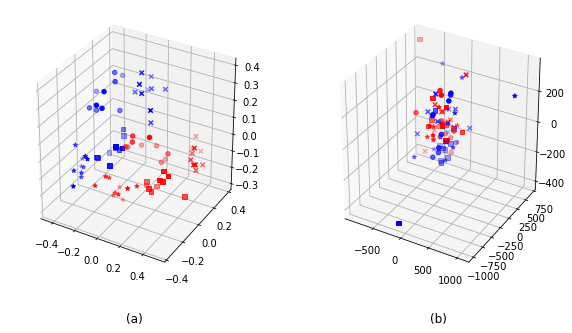

500 	 -0.88326669 	 0.50329959 	 0.69331139 	 0.69326031


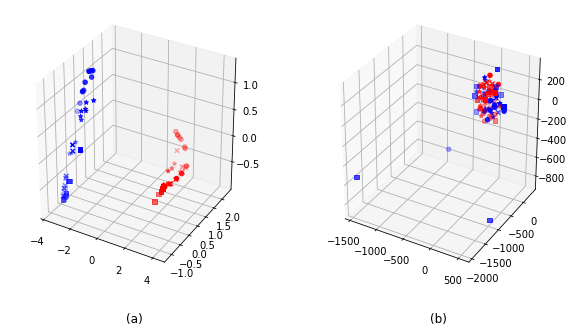

1000 	 -0.88329536 	 0.50324076 	 0.69334519 	 0.69319308


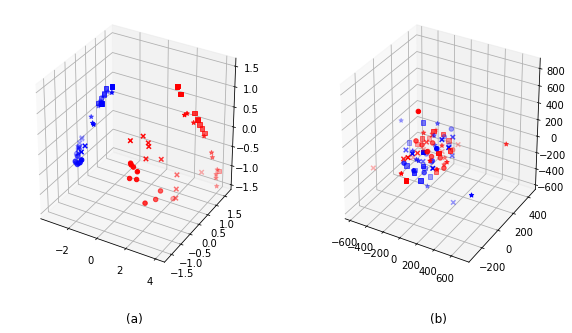

1500 	 -0.88311583 	 0.50321108 	 0.69316715 	 0.69316155


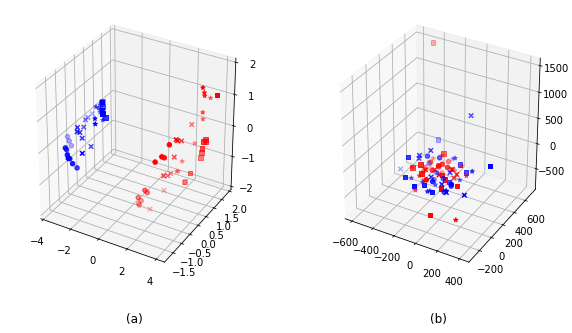

2000 	 -0.88310957 	 0.50321281 	 0.69316119 	 0.69316125


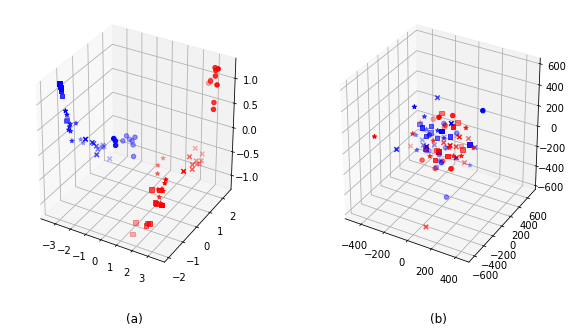

2500 	 -0.88309950 	 0.50320703 	 0.69315434 	 0.69315225


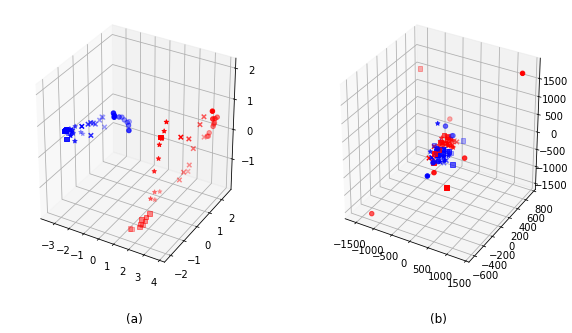

3000 	 -0.88309705 	 0.50320727 	 0.69315255 	 0.69315183


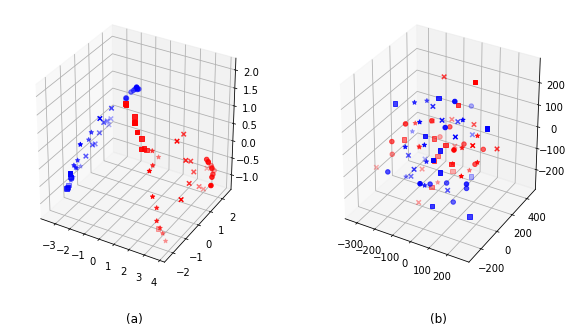

3500 	 -0.88309324 	 0.50320590 	 0.69315034 	 0.69314885


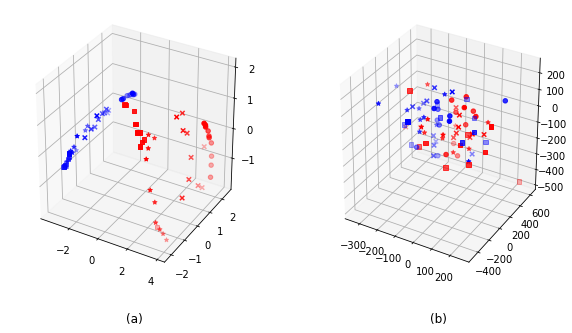

4000 	 -0.88309330 	 0.50320518 	 0.69314986 	 0.69314861


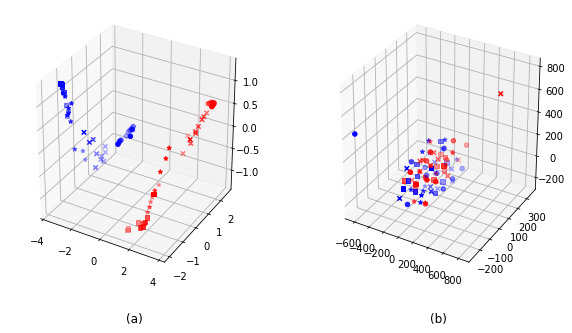

4500 	 -0.88309103 	 0.50320494 	 0.69314820 	 0.69314778


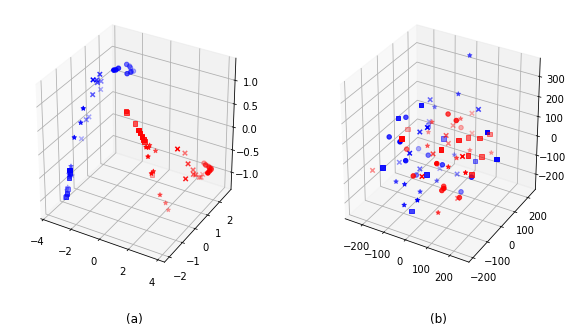

5000 	 -0.88309079 	 0.50320476 	 0.69314796 	 0.69314760


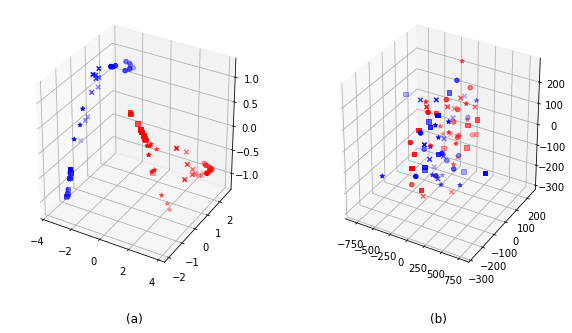

5500 	 -0.88309067 	 0.50320470 	 0.69314784 	 0.69314754


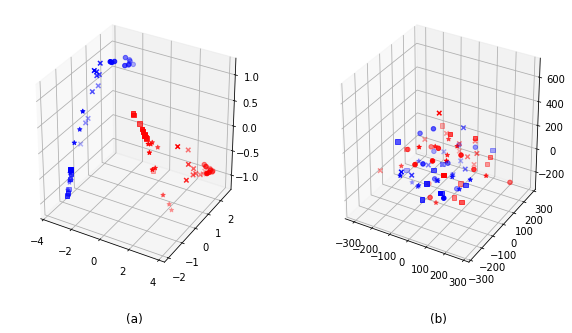

6000 	 -0.88306862 	 0.50320637 	 0.69312888 	 0.69314754


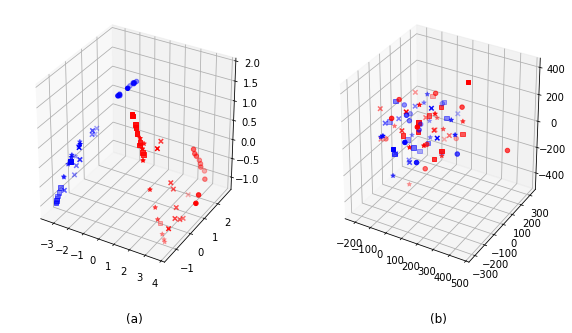

6500 	 -0.88309282 	 0.50320530 	 0.69314909 	 0.69314903


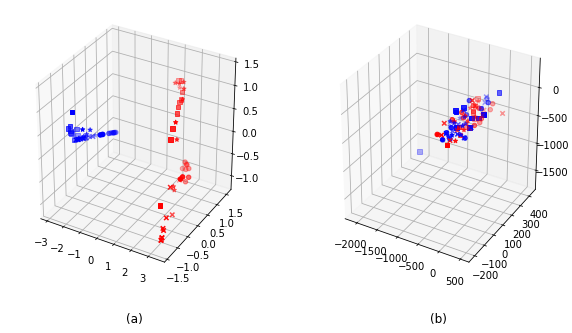

7000 	 -0.88309091 	 0.50320488 	 0.69314802 	 0.69314778


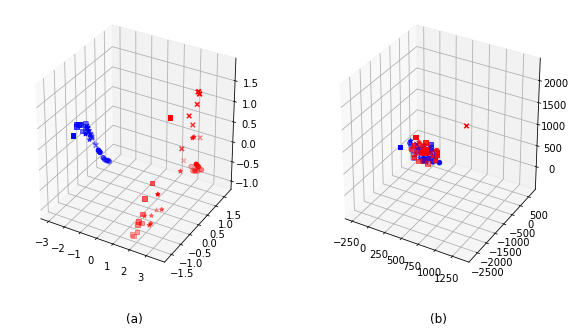

7500 	 -0.88309038 	 0.50320452 	 0.69314754 	 0.69314736


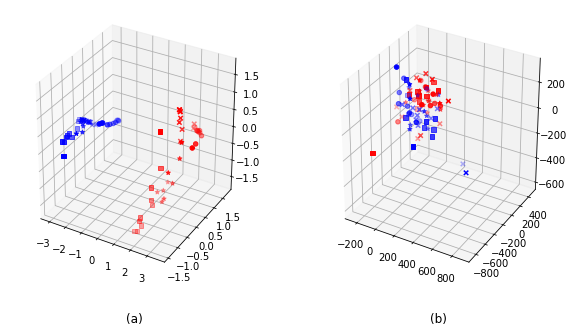

8000 	 -0.88309014 	 0.50320441 	 0.69314742 	 0.69314712


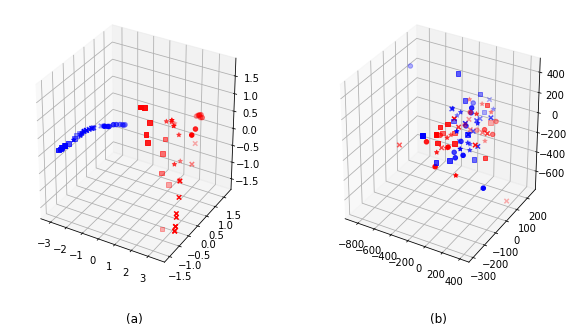

8500 	 -0.88308972 	 0.50320435 	 0.69314718 	 0.69314688


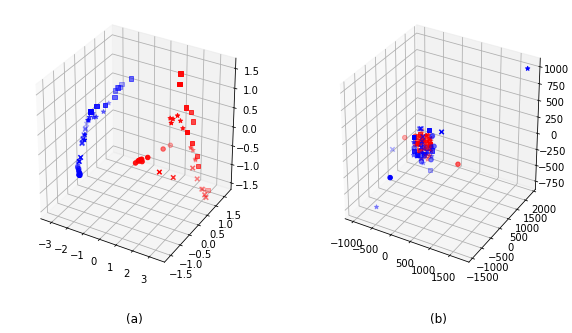

9000 	 -0.88308960 	 0.50320429 	 0.69314700 	 0.69314688


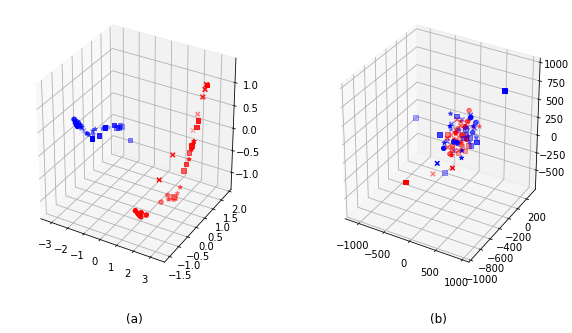

9500 	 -0.88308960 	 0.50320423 	 0.69314694 	 0.69314688


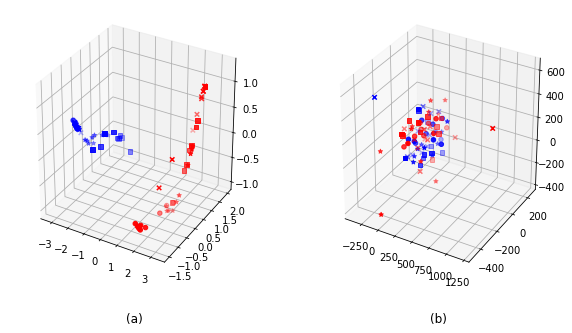

10000 	 -0.88308954 	 0.50320423 	 0.69314688 	 0.69314688


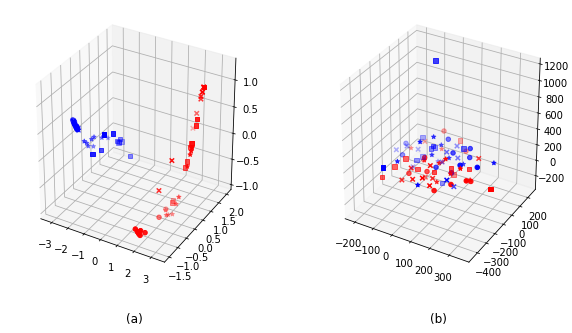

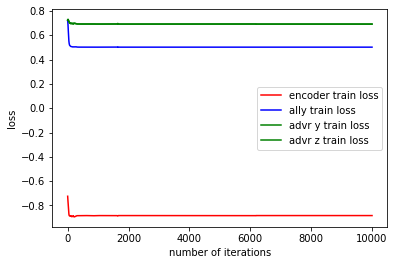

In [138]:
alpha = 0.5
lr_encd = 0.01
lr_ally = 0.001
lr_advr = 0.001
n_iter_gan = 10001
d_reps = 1

# alpha = 0.5
# lr_encd = 0.01
# lr_ally = 0.001
# lr_advr = 0.0001
# n_iter_gan = 5001
# d_reps = 2


encoder = train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True)

# Training Independently

In [ ]:
encoding_dimension = 2
encoder.eval()

In [ ]:
ally = Ally(
    input_size=encoding_dimension, 
    hidden_size=encoding_dimension, 
    output_size=y_ally_torch.shape[1])
criterion = torch.nn.BCEWithLogitsLoss()
ally_optimizer = optimizer(ally.parameters(), lr=0.01)

print("epoch \t ally_train")

ally.train()

n_iter = 10001
    
for epoch in range(n_iter):
    X_ganencoded = encoder(X_torch)
    y_ally_torch_hat = ally(X_ganencoded)
    ally_optimizer.zero_grad()
    ally_loss = criterion(y_ally_torch_hat, y_ally_torch)
    ally_loss.backward()
    ally_optimizer.step()
    
    if epoch%1000!=0:
        continue

    print('{} \t {:.8f}'.format(
        epoch, 
        ally_loss.item(),
    ))
    

In [ ]:
adversary = Adversary(
    input_size=encoding_dimension, 
    hidden_size=encoding_dimension, 
    output_size=y_advr_torch.shape[1])

advr_optimizer = optimizer(adversary.parameters(), lr=0.01)

print("epoch \t advr_train")

adversary.train()
    
for epoch in range(n_iter):
    X_ganencoded = encoder(X_torch)
    y_advr_torch_hat = adversary(X_ganencoded)
    advr_optimizer.zero_grad()
    advr_loss = criterion(y_advr_torch_hat, y_advr_torch)
    advr_loss.backward()
    advr_optimizer.step()
    
    if epoch%1000!=0:
        continue
    
    print('{} \t {:.8f}'.format(
        epoch, 
        advr_loss.item(),
    ))
    

# DP

In [ ]:
def laplaceMechanism(x, epsilon):
    return x + np.random.laplace(0, 1.0/epsilon, x.shape)

In [ ]:
epsilons = [1, 10, 100, 1000]
for epsilon in epsilons:
    X_dp = laplaceMechanism(X_normalized, epsilon)

    class_plot(X_dp, title="DP at epsilon={}".format(epsilon))

In [ ]:
np.random.laplace(0, 1.0/100000, X_dp.shape)